# Import Libraries

In [1]:
# Pandas is a software library written for the Python programming language for data manipulation and analysis.
import pandas as pd
# NumPy is a library for the Python programming language, adding support for large, multi-dimensional arrays and matrices, along with a large collection of high-level mathematical functions to operate on these arrays
import numpy as np
# Matplotlib is a plotting library for python and pyplot gives us a MatLab like plotting framework. We will use this in our plotter function to plot data.
import matplotlib.pyplot as plt
# Seaborn is a Python data visualization library based on matplotlib. It provides a high-level interface for drawing attractive and informative statistical graphics
import seaborn as sns
# Preprocessing allows us to standarsize our data
from sklearn import preprocessing
# Allows us to split our data into training and testing data
from sklearn.model_selection import train_test_split
# Allows us to test parameters of classification algorithms and find the best one
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
# Multiple linear regression model
from sklearn import linear_model
# Random Forest Classifier
from sklearn.ensemble import RandomForestRegressor
# Gradient Boosting Regressor
from sklearn.ensemble import GradientBoostingRegressor
# Principal component analysis
from sklearn.decomposition import PCA
# Different distributions
from scipy.stats import norm, lognorm, johnsonsu

from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
# from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV

# Import Data Sets

In [2]:
# Setting this option will print all collumns of a dataframe and all of the data in a feature
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [3]:
# load train df
train = pd.read_csv('train.csv')
# load test df
test = pd.read_csv('train.csv')
# Drop the  'Id' colum since it's unnecessary for the prediction process
train.drop(['Id'], axis=1, inplace=True)
test.drop(['Id'], axis=1, inplace=True)

# Preprocessing

In [4]:
# Some numerical features are actually really categories
train = train.replace({"MSSubClass" : {20 : "SC20", 30 : "SC30", 40 : "SC40", 45 : "SC45", 
                                 50 : "SC50", 60 : "SC60", 70 : "SC70", 75 : "SC75", 
                                 80 : "SC80", 85 : "SC85", 90 : "SC90", 120 : "SC120", 
                                 150 : "SC150", 160 : "SC160", 180 : "SC180", 190 : "SC190"},
                        "MoSold" : {1 : "Jan", 2 : "Feb", 3 : "Mar", 4 : "Apr", 5 : "May", 6 : "Jun",
                                    7 : "Jul", 8 : "Aug", 9 : "Sep", 10 : "Oct", 11 : "Nov", 12 : "Dec"}
})

# Exploratory Data Analysis

In [5]:
# Qualitative to quantitative encode function
def encode(data_frame, feature):
    ordering = pd.DataFrame()
    ordering['val'] = data_frame[feature].unique()
    ordering.index = ordering['val']
    
# Count mean SalePrice values for unique feature's category
    ordering['spmean'] = data_frame[[feature, 'SalePrice']].groupby(feature).mean()['SalePrice']
    ordering.sort_values('spmean', inplace=True)
    
# Create dictionary {category : value}, where value is in range from 1
    ordering['ordering'] = range(1, ordering.shape[0]+1)
    ordering = ordering['ordering'].to_dict()
# Add feature + 'E' column
    for category, order in ordering.items():
        data_frame.loc[data_frame[feature] == category, feature+'_E'] = order

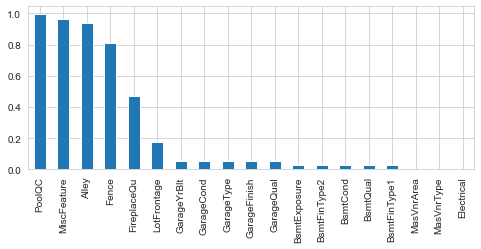

In [6]:
# Show NaN as % of missing values in the column
plt.figure(figsize=(8,3))
sns.set_style("whitegrid")
is_null_list = train.isnull().sum() / len(train)
is_null_list.sort_values(ascending=False, inplace=True)
is_null_list[is_null_list > 0].plot.bar()
plt.show()

In [7]:
# Drop empty rows and columns that have more than 15% NaN
train.dropna(axis=1, how='any', thresh=len(train)*0.85, inplace=True)
train.dropna(axis=0, how='all', inplace=True)

In [8]:
quantitative = list(train.describe(include=np.number).columns)
qualitative = list(train.describe(include=np.object_).columns)

In [9]:
# Apply the encode function
qual_encoded = []
for q in qualitative:  
    encode(train, q)
    qual_encoded.append(q+'_E')

features = quantitative + qual_encoded

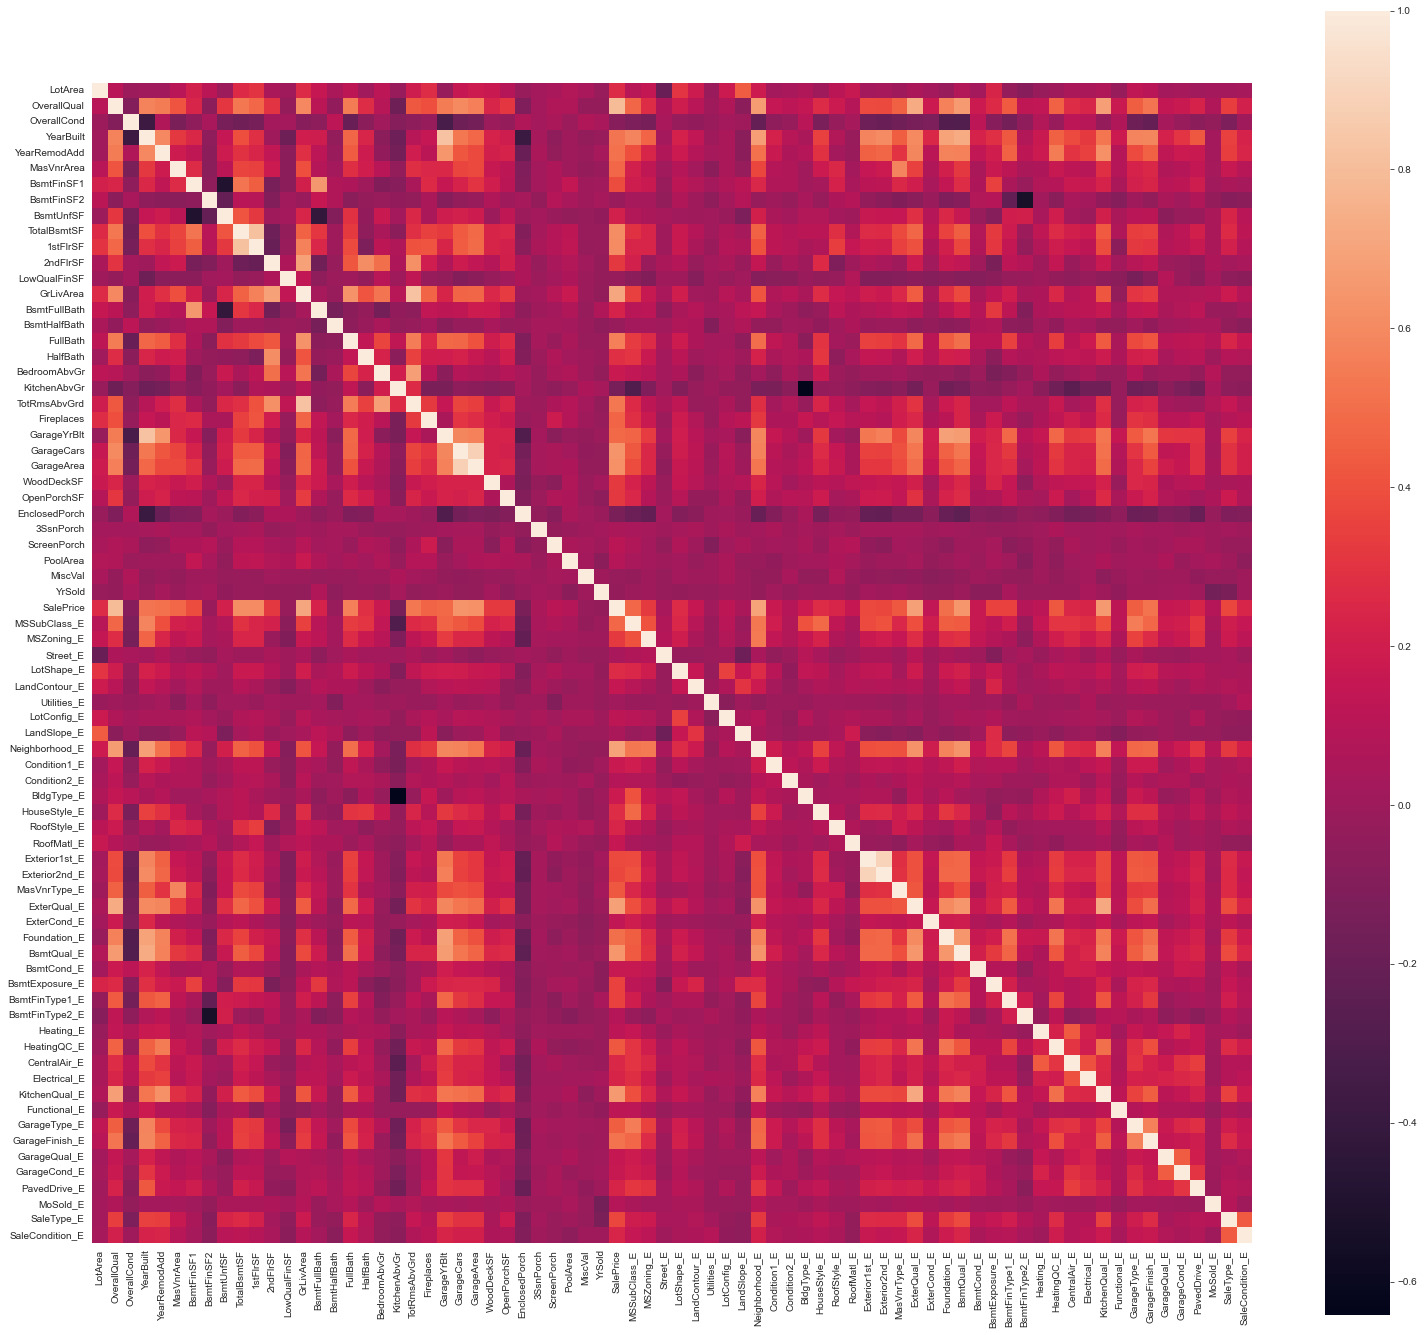

In [10]:
# Plot Correlation matrix
plt.figure(figsize=(26,24))
corr_table = train[features].corr()
sns.heatmap(corr_table, square=True)
plt.show()

In [11]:
# Check correlation between variation to avoid multicollinearity
some_list = []
for i, row in corr_table.iterrows():
    row.sort_values(ascending=False, inplace=True)
    if row.iloc[1]>0.6:
        print('\t', i, '\n', row[1:5], '\n')
    if row.iloc[1]<-0.6:
        print('\t', i, '\n', row[-4:-1], '\n')

	 OverallQual 
 SalePrice         0.790982
ExterQual_E       0.726278
KitchenQual_E     0.673331
Neighborhood_E    0.667647
Name: OverallQual, dtype: float64 

	 YearBuilt 
 GarageYrBlt       0.825667
BsmtQual_E        0.725563
Foundation_E      0.694441
Neighborhood_E    0.675780
Name: YearBuilt, dtype: float64 

	 YearRemodAdd 
 GarageYrBlt      0.642277
KitchenQual_E    0.625316
YearBuilt        0.592855
ExterQual_E      0.587318
Name: YearRemodAdd, dtype: float64 

	 BsmtFinSF1 
 BsmtFullBath    0.649212
TotalBsmtSF     0.522396
1stFlrSF        0.445863
SalePrice       0.386420
Name: BsmtFinSF1, dtype: float64 

	 TotalBsmtSF 
 1stFlrSF       0.819530
SalePrice      0.613581
OverallQual    0.537808
BsmtFinSF1     0.522396
Name: TotalBsmtSF, dtype: float64 

	 1stFlrSF 
 TotalBsmtSF    0.819530
SalePrice      0.605852
GrLivArea      0.566024
GarageArea     0.489782
Name: 1stFlrSF, dtype: float64 

	 2ndFlrSF 
 GrLivArea       0.687501
TotRmsAbvGrd    0.616423
HalfBath        0.60970

In [12]:
# feautures that we deleted
feautures_del = ['GarageYrBlt', 'Foundation', 'TotalBsmtSF', '2ndFlrSF', 'TotRmsAbvGrd', 'HalfBath', 'GarageArea', 'Exterior2nd']

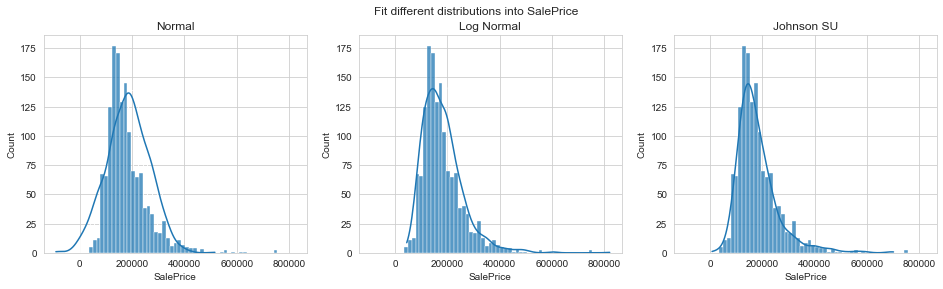

In [13]:
# FutureWarning: `distplot` is a deprecated function and will be removed in a future version.
# That's why let's use histplot without fit method

r_size=1500
y = train['SalePrice']
fig, axes = plt.subplots(1, 3, figsize=(16,4), sharex=True)
fig.suptitle('Fit different distributions into SalePrice')

# Normal
loc1, scale1 = norm.fit(y)
r1 = norm.rvs(loc1, scale1, size=r_size)
sns.histplot(data=r1, kde='True', ax=axes[0], alpha = 0)
sns.histplot(data=y, ax=axes[0])
axes[0].set_title('Normal')

# Log Normal
s1, loc2, scale2 = lognorm.fit(y)
r2 = lognorm.rvs(s1, loc2, scale2, size=r_size)
sns.histplot(data=r2, kde='True', ax=axes[1], alpha = 0)
sns.histplot(data=y, ax=axes[1])
axes[1].set_title('Log Normal')

# Johnson SU
a1, b1, loc3, scale3 = johnsonsu.fit(y)
r3 = johnsonsu.rvs(a1, b1, loc3, scale3, size=r_size)
sns.histplot(data=r3, kde='True', ax=axes[2], alpha = 0)
sns.histplot(data=y, ax=axes[2])
axes[2].set_title('Johnson SU')

plt.show()

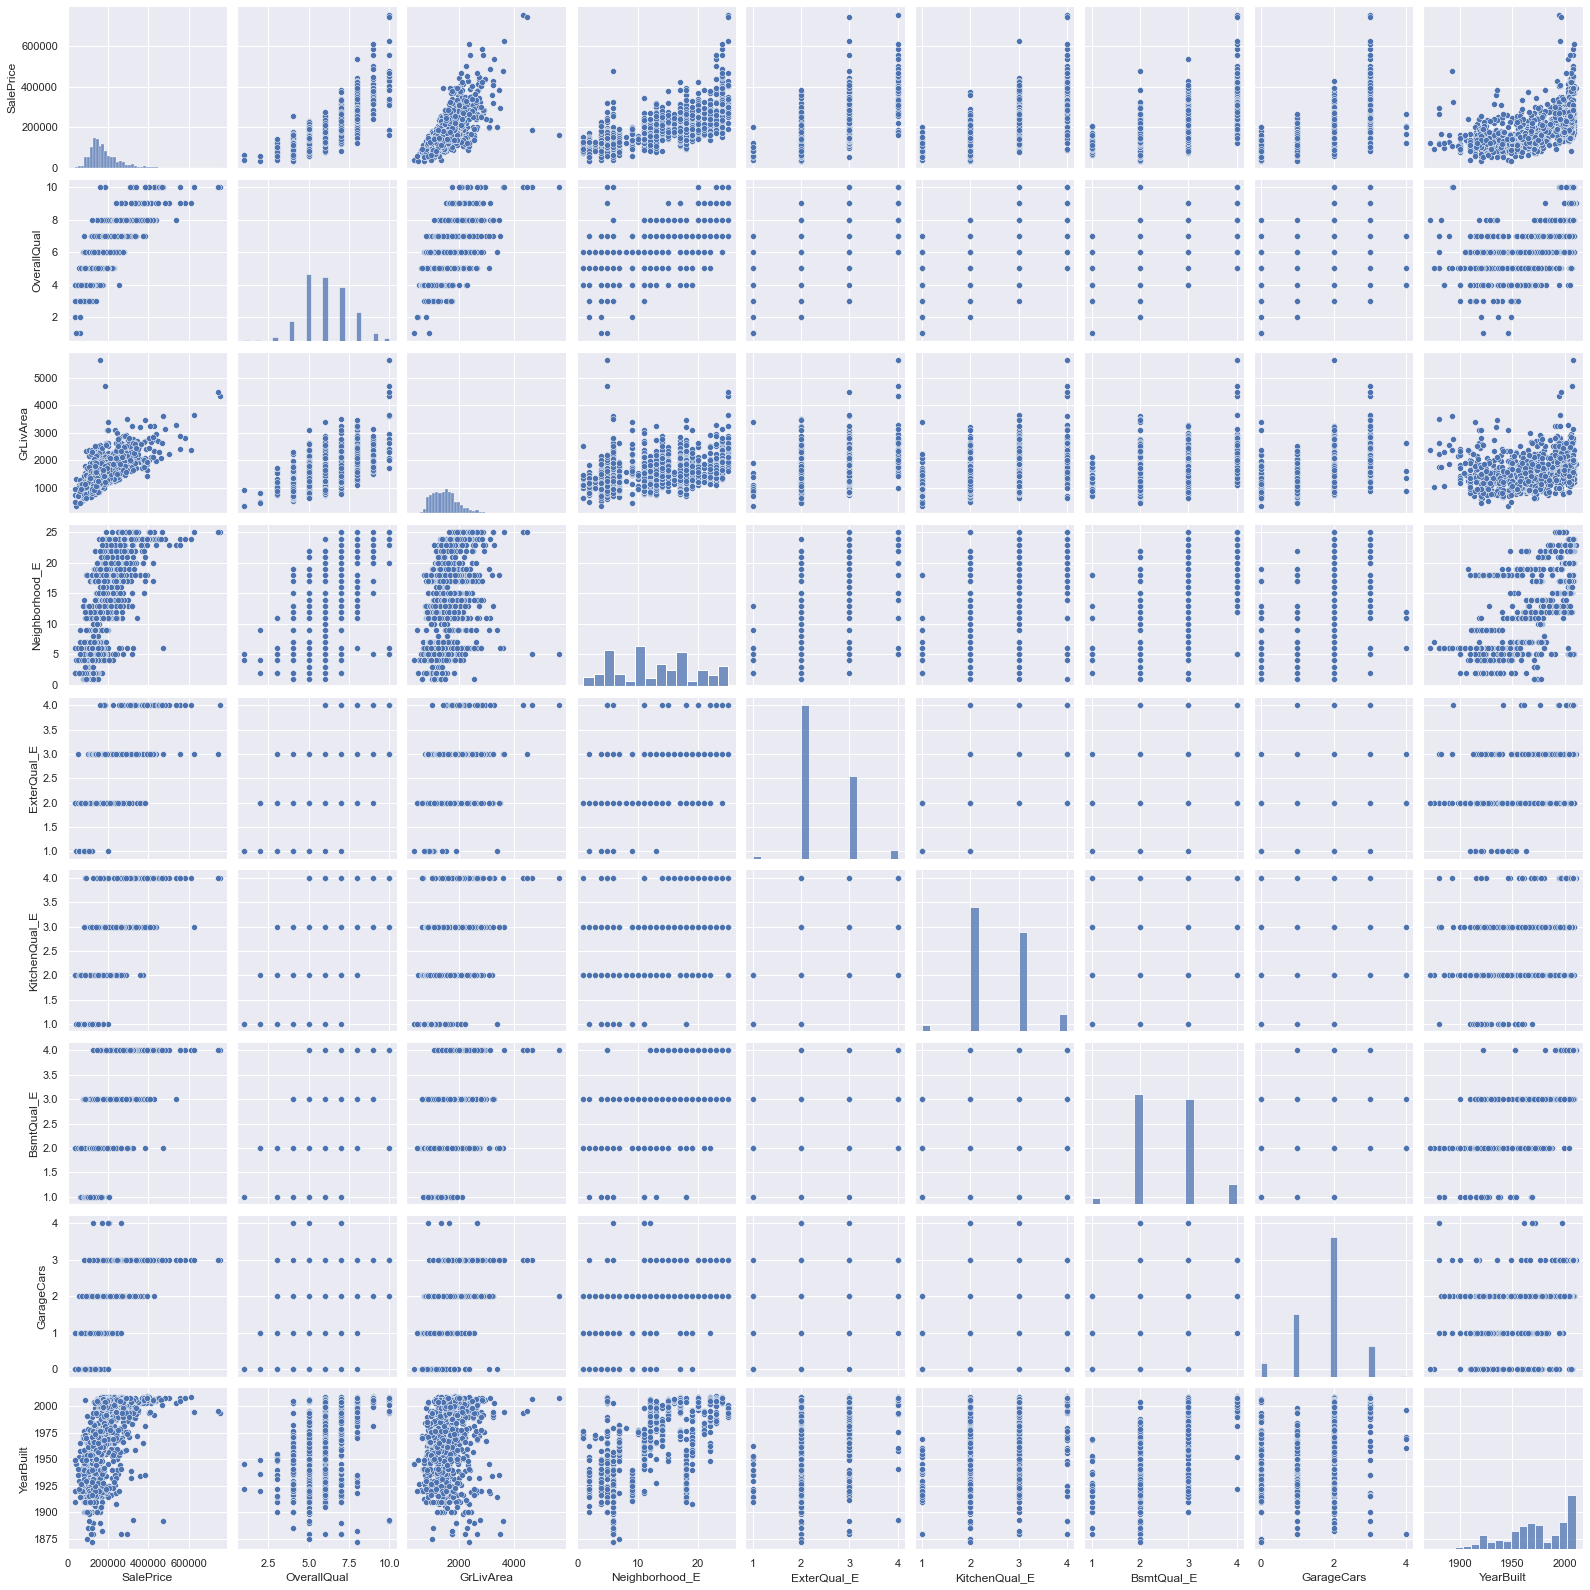

In [14]:
# Do some pairplot
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'Neighborhood_E', 'ExterQual_E', 'KitchenQual_E', 'BsmtQual_E', 'GarageCars','YearBuilt']
sns.pairplot(train[cols], height = 2.5)
plt.show();

# Model Development

In [15]:
# load train df
train = pd.read_csv('train.csv')
# load test df
test = pd.read_csv('test.csv')
# Drop the  'Id' colum since it's unnecessary for the prediction process
train.drop(['Id'], axis=1, inplace=True)
test.drop(['Id'], axis=1, inplace=True)

In [16]:
# Deleting outliers
train = train[train.GrLivArea < 4500]
train.reset_index(drop=True, inplace=True)

In [17]:
# We use the numpy fuction log1p which applies log(1+x) to all elements of the column
train["SalePrice"] = np.log1p(train["SalePrice"])
y = train.SalePrice.reset_index(drop=True)
train_features = train.drop('SalePrice', axis=1)
test_features = test
features = train_features.append(test_features, sort=False)

In [18]:
test_features.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [19]:
# Some of the non-numeric predictors are stored as numbers; we convert them into strings 
features['MSSubClass'] = features['MSSubClass'].apply(str)
features['YrSold'] = features['YrSold'].astype(str)
features['MoSold'] = features['MoSold'].astype(str)
features['Functional'] = features['Functional'].fillna('Typ') 
features['Electrical'] = features['Electrical'].fillna("SBrkr") 
features['KitchenQual'] = features['KitchenQual'].fillna("TA") 
features["PoolQC"] = features["PoolQC"].fillna("None")
features['Exterior1st'] = features['Exterior1st'].fillna(features['Exterior1st'].mode()[0]) 
features['Exterior2nd'] = features['Exterior2nd'].fillna(features['Exterior2nd'].mode()[0])
features['SaleType'] = features['SaleType'].fillna(features['SaleType'].mode()[0])
features["PoolQC"] = features["PoolQC"].fillna("None")

In [20]:
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    features[col] = features[col].fillna(0)
for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
    features[col] = features[col].fillna('None')
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    features[col] = features[col].fillna('None')

features['MSZoning'] = features.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))

In [21]:
quantitative = list(features.describe(include=np.number).columns)
qualitative = list(features.describe(include=np.object_).columns)
features[quantitative] = features[quantitative].apply(lambda x: x.fillna(x.median()),axis=0)
features[qualitative] = features[qualitative].apply(lambda x: x.fillna("None"),axis=0)

In [22]:
# Check NaN
features.isna().sum().sum()

0

In [23]:
feautures_del

['GarageYrBlt',
 'Foundation',
 'TotalBsmtSF',
 '2ndFlrSF',
 'TotRmsAbvGrd',
 'HalfBath',
 'GarageArea',
 'Exterior2nd']

In [24]:
features = features.drop(feautures_del, axis=1)

features['YrBltAndRemod']=features['YearBuilt']+features['YearRemodAdd']

features['Total_sqr_footage'] = (features['BsmtFinSF1'] + features['BsmtFinSF2'] +
                                 features['1stFlrSF'])

features['Total_Bathrooms'] = (features['FullBath'] +
                               features['BsmtFullBath'] + (0.5 * features['BsmtHalfBath']))

features['Total_porch_sf'] = (features['OpenPorchSF'] + features['3SsnPorch'] +
                              features['EnclosedPorch'] + features['ScreenPorch'] +
                              features['WoodDeckSF'])

In [25]:
# simplified features
features['haspool'] = features['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
features['hasfireplace'] = features['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

In [26]:
final_features = pd.get_dummies(features).reset_index(drop=True)
X = final_features.iloc[:len(y), :]
X_sub = final_features.iloc[len(X):, :]

In [27]:
features.shape

(2917, 77)

In [28]:
# Drop outliers
outliers = [30, 88, 462, 631, 1322]
X = X.drop(X.index[outliers])
y = y.drop(y.index[outliers])

In [29]:
overfit = []
for i in X.columns:
    counts = X[i].value_counts()
    zeros = counts.iloc[0]
    if zeros / len(X) * 100 > 99.94:
        overfit.append(i)

overfit = list(overfit)
overfit.append('MSZoning_C (all)')
overfit

['MSSubClass_150', 'Utilities_None', 'MSZoning_C (all)']

In [30]:
X = X.drop(overfit, axis=1).copy()
X_sub = X_sub.drop(overfit, axis=1).copy()

In [31]:
X.shape

(1453, 307)

# Model Development II

In [32]:
# Standardize the data in X then reassign it to the variable X using the transform
transform = preprocessing.StandardScaler()
X = transform.fit_transform(X)
# Sclit the data to train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=38)

In [33]:
# RandomForestRegressor Score with defaults parameters
rfc = RandomForestRegressor(random_state=38)
rfc.fit(X_train, y_train).score(X_test, y_test)

0.8814330337515337

In [34]:
# GradientBoostingRegressor Score with defaults parameters
reg = GradientBoostingRegressor(random_state=38)
reg.fit(X_train, y_train).score(X_test, y_test)

0.8993828513341553

In [35]:
# Visualization of the features importance
feats = {}
for feature, importance in zip(features.columns, rfc.feature_importances_):
    feats[feature] = importance
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-Importance'})
importances = importances.sort_values(by='Gini-Importance', ascending=False)
importances = importances.reset_index()
importances = importances.rename(columns={'index': 'Features'})
importances

,Features,Gini-Importance
0,LotFrontage,5.417174e-01
1,Condition1,1.187964e-01
2,BsmtCond,7.094408e-02
3,LandSlope,4.122794e-02
4,YearRemodAdd,2.950730e-02
...,...,...
72,KitchenAbvGr,4.547211e-06
73,BsmtFinSF1,9.194497e-07
74,hasfireplace,9.338325e-08
75,MiscFeature,5.898652e-08


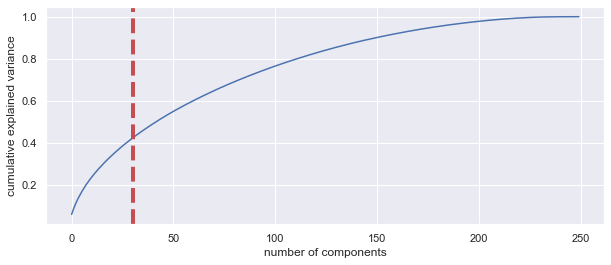

In [36]:
# Use Principal component analysis
# Set n_components to 250 to see the variance of all generated features
pca_test = PCA(n_components=250)
pca_test.fit(X_train)

plt.figure(figsize=(10,4))
plt.plot(np.cumsum(pca_test.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.axvline(linewidth=4, color='r', linestyle = '--', x=30, ymin=0, ymax=1)
plt.show()

In [37]:
pca = PCA(n_components=30)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

In [38]:
rfc.fit(X_train_pca, y_train).score(X_test_pca, y_test)

0.8610132152468372

In [39]:
reg.fit(X_train_pca, y_train).score(X_test_pca, y_test)

0.8689603855595642

# Final Estimation and Prediction

In [40]:
# Define X 
X_train_final = transform.fit_transform(X)
X_test_final = transform.fit_transform(X_sub)

In [41]:
# Use PCA
# pca = PCA(n_components=190)
pca_test.fit(X_train_final)
X_train_final_pca = pca.transform(X_train_final)
X_test_final_pca = pca.transform(X_test_final)
# Generate Gradient Boosting object
reg_opt = GradientBoostingRegressor(random_state=38)

reg.fit(X_train_final_pca, y)
# Define parameters for cross validation
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 200, num = 20)]
learning_rate = [0.005, 0.01, 0.1, 0.15, 0.2, 0.25, 0.3]
hyperparameters = {'n_estimators': n_estimators, 'learning_rate':learning_rate}
# Calculate score
reg_cv = RandomizedSearchCV(reg_opt,
                        hyperparameters,
                        cv = 10,
                        n_jobs=-1,
                        random_state=38)
reg_cv.fit(X_train_final_pca, y)

RandomizedSearchCV(cv=10, estimator=GradientBoostingRegressor(random_state=38),
                   n_jobs=-1,
                   param_distributions={'learning_rate': [0.005, 0.01, 0.1,
                                                          0.15, 0.2, 0.25,
                                                          0.3],
                                        'n_estimators': [10, 20, 30, 40, 50, 60,
                                                         70, 80, 90, 100, 110,
                                                         120, 130, 140, 150,
                                                         160, 170, 180, 190,
                                                         200]},
                   random_state=38)

In [42]:
# Prdict SalePrice
test['SalePrice'] = reg_cv.best_estimator_.predict(X_test_final_pca)

# Save results

In [43]:
prediction = pd.DataFrame()

index_n = np.linspace(1461, 2919, 1459)
prediction['Id'] = index_n
prediction['Id'] = prediction['Id'].astype('int')
prediction['SalePrice'] = np.expm1(test['SalePrice'])
prediction.head()

,Id,SalePrice
0,1461,130022.303320
1,1462,154531.132791
2,1463,182826.782468
3,1464,208396.734713
4,1465,182661.029040


In [44]:
pd.DataFrame(prediction).to_csv('prediction06.csv', index=False)